# ***Natural Language Processing Assignment-2 Solution***

## ***Basic Level***

##### ***Step-1: Importing necessary libraries***

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch
from gensim import corpora
from sklearn.metrics import classification_report

##### ***Step-2: Loading yelp review dataset***

In [3]:
df = pd.read_csv('yelp_reviews_subset_2.csv')
df

,Unnamed: 0,Text,Labels
0,0,My expectations for McDonalds are t rarely hig...,0
1,1,I've tried to give this McDonalds a chance but...,0
2,2,This McDonald's is so bad it's amazing. \n\nO...,0
3,3,We had the worst possible experience at the Ea...,0
4,4,They burned my fish and they burned it bad. O...,2
...,...,...,...
495,495,This place is PHENOMENAL.\nI got my bunny here...,4
496,496,"This is a bizarre CVS, the kind you would only...",1
497,497,"I go to this CVS all the time, since I work in...",1
498,498,"Never again. Let me repeat, never again. \n\nT...",0


##### ***Step-3: Making the sentiment column***

C:\Users\JAYENT DEV\AppData\Local\Temp\ipykernel_10864\586133965.py:14: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  pd.value_counts(df['sentiment']).plot.bar(title="Sentiment distribution in df")


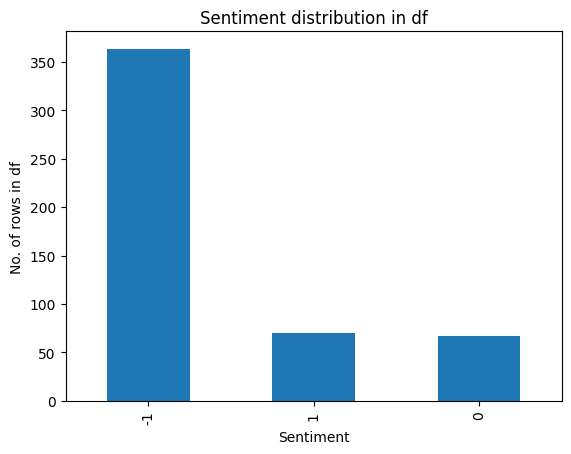

In [4]:
def map_sentiment(stars_received):
    if stars_received <= 2:
        return -1
    elif stars_received == 3:
        return 0
    else:
        return 1


# Mapping stars to sentiment into three categories
df['sentiment'] = [ map_sentiment(x) for x in df['Labels']]
# Plotting the sentiment distribution
plt.figure()
pd.value_counts(df['sentiment']).plot.bar(title="Sentiment distribution in df")
plt.xlabel("Sentiment")
plt.ylabel("No. of rows in df")
plt.show()

##### ***Step-4: Tokenizing the text and stemming the word using NLTK tools***

In [5]:
df['tokenized_text'] = [word_tokenize(text) for text in df['Text']]
print(df['tokenized_text'].head(10))

ps = PorterStemmer()
df['stemmed_tokens'] = [[ps.stem(word) for word in tokens] for tokens in df['tokenized_text']]

df['stemmed_tokens'].head(10)

0    [My, expectations, for, McDonalds, are, t, rar...
1    [I, 've, tried, to, give, this, McDonalds, a, ...
2    [This, McDonald, 's, is, so, bad, it, 's, amaz...
3    [We, had, the, worst, possible, experience, at...
4    [They, burned, my, fish, and, they, burned, it...
5    [Some, how, even, though, the, food, at, this,...
6    [Mmm, ..., peppermint, mocha\n\nIn, my, quest,...
7    [If, there, was, ever, a, \, '', get, your, co...
8    [I, just, realized, they, remodeled, this, one...
9    [Great, location, !, Close, to, shops, and, th...
Name: tokenized_text, dtype: object


0    [my, expect, for, mcdonald, are, t, rare, high...
1    [i, 've, tri, to, give, thi, mcdonald, a, chan...
2    [thi, mcdonald, 's, is, so, bad, it, 's, amaz,...
3    [we, had, the, worst, possibl, experi, at, the...
4    [they, burn, my, fish, and, they, burn, it, ba...
5    [some, how, even, though, the, food, at, thi, ...
6    [mmm, ..., peppermint, mocha\n\nin, my, quest,...
7    [if, there, wa, ever, a, \, '', get, your, cof...
8    [i, just, realiz, they, remodel, thi, one, rec...
9    [great, locat, !, close, to, shop, and, theatr...
Name: stemmed_tokens, dtype: object

##### ***Step-5: Test_Train_Split using scikit-learn module***

In [6]:
# Train Test Split Function
def split_train_test(df, test_size=0.3, shuffle_state=True):
    X_train, X_test, Y_train, Y_test = train_test_split(df[["Text", "Labels", "tokenized_text", "stemmed_tokens"]], df['sentiment'], shuffle=shuffle_state, test_size=test_size, random_state=15)
    print("Value counts for Train sentiments")
    print(Y_train.value_counts())
    print("Value counts for Test sentiments")
    print(Y_test.value_counts())
    print(type(X_train))
    print(type(Y_train))
    X_train = X_train.reset_index()
    X_test = X_test.reset_index()
    Y_train = Y_train.to_frame()
    Y_train = Y_train.reset_index()
    Y_test = Y_test.to_frame()
    Y_test = Y_test.reset_index()
    print(X_train.head())
    return X_train, X_test, Y_train, Y_test

# Call the train_test_split
X_train, X_test, Y_train, Y_test = split_train_test(df)

Value counts for Train sentiments
sentiment
-1    255
 1     49
 0     46
Name: count, dtype: int64
Value counts for Test sentiments
sentiment
-1    108
 1     21
 0     21
Name: count, dtype: int64
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>
   index                                               Text  Labels  \
0    139  The food is standard American fare--a bit over...       1   
1    129  I'm not much of a beer drinker, but my fiancee...       3   
2    258  ok so i've eaten here more than once but just ...       1   
3    227  Food was ok had a steak w/ shrimp side Ass mas...       1   
4     60  He was incredibly sexist/homophobic. He could ...       0   

                                      tokenized_text  \
0  [The, food, is, standard, American, fare, --, ...   
1  [I, 'm, not, much, of, a, beer, drinker, ,, bu...   
2  [ok, so, i, 've, eaten, here, more, than, once...   
3  [Food, was, ok, had, a, steak, w/, shrimp, sid...   
4  [He, was, incredi

##### ***Step-6: Setting up the device either GPU or CPU***

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device available for running: ", device)

Device available for running:  cuda


##### ***Step-7: Writing FeedForwardNeuralNetModel funcion code***

In [8]:
class FeedforwardNeuralNetModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(FeedforwardNeuralNetModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.fc3(out)
        return F.softmax(out, dim=1)

##### ***Step-8: Making dictionary of tokens with and without padding***

In [9]:
# Function to return the dictionary either with padding word or without padding
def make_dict(top_data_df_small, padding=True):
    if padding:
        print("Dictionary with padded token added")
        review_dict = corpora.Dictionary([['pad']])
        review_dict.add_documents(top_data_df_small['stemmed_tokens'])
    else:
        print("Dictionary without padding")
        review_dict = corpora.Dictionary(top_data_df_small['stemmed_tokens'])
    return review_dict

# Make the dictionary without padding for the basic models
review_dict = make_dict(df, padding=False)
print("Number of unique words in the dictionary: ", len(review_dict))

Dictionary without padding
Number of unique words in the dictionary:  5587


##### ***Step-9: Creating bag of words vector from tokenized words and sentiment label tensor output***

In [10]:
VOCAB_SIZE = 30056
NUM_LABELS = 3

# Function to make bow vector to be used as input to network
def make_bow_vector(review_dict, sentence):
    vec = torch.zeros(VOCAB_SIZE, dtype=torch.float64, device=device)
    for word in sentence:
        vec[review_dict.token2id[word]] += 1
    return vec.view(1, -1).float()

# Function to get the output tensor
def make_target(label):
    if label == -1:
        return torch.tensor([0], dtype=torch.long, device=device)
    elif label == 0:
        return torch.tensor([1], dtype=torch.long, device=device)
    else:
        return torch.tensor([2], dtype=torch.long, device=device)

##### ***Step-10***

In [11]:
VOCAB_SIZE = len(review_dict)

input_dim = VOCAB_SIZE
hidden_dim = 500
output_dim = 3
num_epochs = 100

ff_nn_bow_model = FeedforwardNeuralNetModel(input_dim, hidden_dim, output_dim)
ff_nn_bow_model = ff_nn_bow_model.to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(ff_nn_bow_model.parameters(), lr=1e-3)

##### ***Step-11***

In [12]:
# Open the file for writing loss
ffnn_loss_file_name = 'ffnn_bow_class_big_loss_500_epoch_100_less_lr.csv'
f = open(ffnn_loss_file_name,'w')
f.write('iter, loss')
f.write('\n')
losses = []
iter = 0
# Start training
for epoch in range(num_epochs):
    if (epoch+1) % 25 == 0:
        print("Epoch completed: " + str(epoch+1))
    train_loss = 0
    for index, row in X_train.iterrows():
        # Clearing the accumulated gradients
        optimizer.zero_grad()
        
        bow_vec = make_bow_vector(review_dict, row['stemmed_tokens'])
        probs = ff_nn_bow_model(bow_vec)

        # Get the target label
        target = make_target(Y_train['sentiment'][index])
        loss = loss_function(probs, target)

        # Accumulating the loss over time
        train_loss += loss.item()

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()
    f.write(str((epoch+1)) + "," + str(train_loss / len(X_train)))
    f.write('\n')
    train_loss = 0

f.close()

Epoch completed: 25
Epoch completed: 50
Epoch completed: 75
Epoch completed: 100


##### ***Step-12***

              precision    recall  f1-score   support

           0       0.72      1.00      0.84       108
           1       0.00      0.00      0.00        21
           2       0.00      0.00      0.00        21

    accuracy                           0.72       150
   macro avg       0.24      0.33      0.28       150
weighted avg       0.52      0.72      0.60       150

100
Index(['iter', ' loss'], dtype='object')


e:\Python 3.11.9\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
e:\Python 3.11.9\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
e:\Python 3.11.9\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


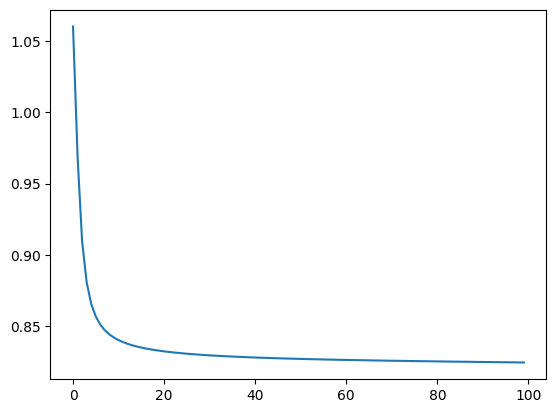

In [13]:
bow_ff_nn_predictions = []
original_lables_ff_bow = []

with torch.no_grad():
    for index, row in X_test.iterrows():
        bow_vec = make_bow_vector(review_dict, row['stemmed_tokens'])
        probs = ff_nn_bow_model(bow_vec)
        bow_ff_nn_predictions.append(torch.argmax(probs, dim=1).cpu().numpy()[0])
        original_lables_ff_bow.append(make_target(Y_test['sentiment'][index]).cpu().numpy()[0])

print(classification_report(original_lables_ff_bow,bow_ff_nn_predictions))
ffnn_loss_df = pd.read_csv(ffnn_loss_file_name)
print(len(ffnn_loss_df))
print(ffnn_loss_df.columns)
ffnn_plt_500_padding_100_epochs = ffnn_loss_df[' loss'].plot()
fig = ffnn_plt_500_padding_100_epochs.get_figure()
fig.savefig("ffnn_bow_loss_500_padding_100_epochs_less_lr.jpg")

## ***Advance Level***

##### ***Step-13: Train the FeedForward Neural Network Model with dropout with regularization***

In [14]:
# Initializing the Feedforward Neural Network model with Dropout
class FeedforwardNeuralNetModel_Dropout(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout_rate=0.3):
        super(FeedforwardNeuralNetModel_Dropout, self).__init__()

        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout_rate)

        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout_rate)

        self.fc3 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.dropout1(out)

        out = self.fc2(out)
        out = self.relu2(out)
        out = self.dropout2(out)

        out = self.fc3(out)
        return F.softmax(out, dim=1)

# Training the Feedforward Neural Network Model with Dropout
ff_nn_bow_model_dropout = FeedforwardNeuralNetModel_Dropout(input_dim, hidden_dim, output_dim, dropout_rate=0.3)
ff_nn_bow_model_dropout.to(device)

loss_function_dropout = nn.CrossEntropyLoss()
optimizer_dropout = torch.optim.SGD(ff_nn_bow_model_dropout.parameters(), lr=1e-3)

ffnn_loss_file_name_dropout = 'ffnn_bow_class_big_loss_500_epoch_100_less_lr_dropout.csv'
f_dropout = open(ffnn_loss_file_name_dropout, 'w')
f_dropout.write('iter, loss\n')
losses_dropout = []
iter_dropout = 0

# Train the model
ff_nn_bow_model_dropout.train()
for epoch in range(num_epochs):
    if (epoch + 1) % 25 == 0:
        print(f"Epoch completed: {epoch + 1}")

    train_loss_dropout = 0

    for index, row in X_train.iterrows():
        optimizer_dropout.zero_grad()

        bow_vec = make_bow_vector(review_dict, row['stemmed_tokens'])
        probs = ff_nn_bow_model_dropout(bow_vec)
        target = make_target(Y_train['sentiment'][index])

        loss = loss_function_dropout(probs, target)
        train_loss_dropout += loss.item()

        # Backward pass and optimization
        loss.backward()
        optimizer_dropout.step()

    # Log average loss for the epoch
    f_dropout.write(f"{epoch + 1},{train_loss_dropout / len(X_train)}\n")
    train_loss_dropout = 0

f_dropout.close()

Epoch completed: 25
Epoch completed: 50
Epoch completed: 75
Epoch completed: 100


##### ***Step-14: Evaluating the performance of the model with dropout on the test dataset***

Classification Report with Dropout:
              precision    recall  f1-score   support

           0       0.72      1.00      0.84       108
           1       0.00      0.00      0.00        21
           2       0.00      0.00      0.00        21

    accuracy                           0.72       150
   macro avg       0.24      0.33      0.28       150
weighted avg       0.52      0.72      0.60       150



e:\Python 3.11.9\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
e:\Python 3.11.9\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
e:\Python 3.11.9\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


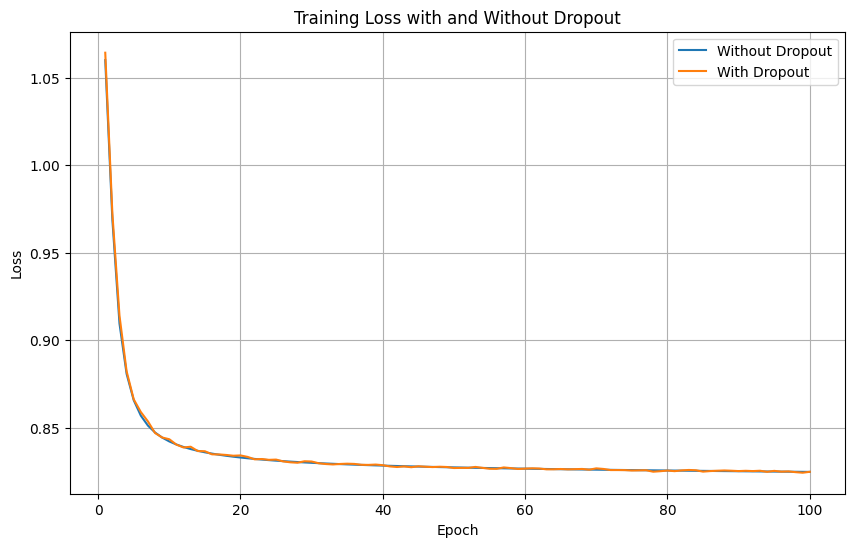

In [15]:
bow_ff_nn_predictions_dropout = []
original_lables_ff_bow_dropout = []

ff_nn_bow_model_dropout.eval() # Set model to evaluation mode
with torch.no_grad():
    for index, row in X_test.iterrows():
        bow_vec = make_bow_vector(review_dict, row['stemmed_tokens'])
        probs = ff_nn_bow_model_dropout(bow_vec)
        bow_ff_nn_predictions_dropout.append(torch.argmax(probs, dim=1).cpu().numpy()[0])
        original_lables_ff_bow_dropout.append(make_target(Y_test['sentiment'][index]).cpu().numpy()[0])

print("Classification Report with Dropout:")
print(classification_report(original_lables_ff_bow_dropout, bow_ff_nn_predictions_dropout))

ffnn_loss_df = pd.read_csv(ffnn_loss_file_name)
ffnn_loss_df_dropout = pd.read_csv(ffnn_loss_file_name_dropout)

plt.figure(figsize=(10, 6))
plt.plot(ffnn_loss_df['iter'], ffnn_loss_df[' loss'], label='Without Dropout')
plt.plot(ffnn_loss_df_dropout['iter'], ffnn_loss_df_dropout[' loss'], label='With Dropout')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss with and Without Dropout')
plt.legend()
plt.grid(True)
plt.savefig("ffnn_bow_loss_comparison_dropout.jpg")
plt.show()